<a href="https://colab.research.google.com/github/BEcemErce/Coursera_JavaProgramming_SolvingProblems_DukeUniversity_assignments/blob/master/evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:

os.chdir('/content/drive/MyDrive/Colab Notebooks/city')

In [ ]:


import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from torch.utils.data import DataLoader
import time
import cv2
from imutils import paths
from sklearn.model_selection import train_test_split
from torch.nn import Module
from unet_orig import UNet
from torch.nn import CrossEntropyLoss, BCEWithLogitsLoss
from torch.optim import AdamW
from tqdm import tqdm
from earlyStopping import EarlyStopping

import torch.utils.data as data


In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
PIN_MEMORY = True if DEVICE == "cuda" else False

In [ ]:
INIT_LR = 0.1
NUM_EPOCHS = 500
BATCH_SIZE = 5
N_CLASS = 20

BASE_OUTPUT ="/content/drive/My Drive/Colab Notebooks/city/output"
CHECKPOINTS_PATH=BASE_OUTPUT+"/checkpoints/"
MODEL_PATH = os.path.join(BASE_OUTPUT, "unet_cityscapes_baseline.pth")
PLOT_PATH = os.path.sep.join([BASE_OUTPUT, "Train_Test_Plot_baseline.png"])


In [ ]:
TEST_PATHS = "/content/drive/MyDrive/gta/data/labels/"


In [ ]:
imagePaths = [f for f in os.listdir(TEST_PATHS) ]

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image

class CustomDataset(Dataset):
    def __init__(self, image_folder, label_folder, transform=None):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.transform = transform

        # Get list of image and label files
        self.image_files = os.listdir(image_folder)
        self.label_files = os.listdir(label_folder)

        # Ensure the number of images and labels match
        assert len(self.image_files) == len(self.label_files), "Number of images and labels must be the same"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and label
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        label_path = os.path.join(self.label_folder, self.label_files[idx])

        img = Image.open(img_path).convert("RGB")
        label = Image.open(label_path).convert("L")  # Assuming labels are grayscale images

        # Apply transformations
        if self.transform:
            img = self.transform(img)
            label = self.transform(label)

        return img, label

In [ ]:
mapping_20 = {
        0: 0,
        1: 0,
        2: 0,
        3: 0,
        4: 0,
        5: 0,
        6: 0,
        7: 1,
        8: 2,
        9: 0,
        10: 0,
        11: 3,
        12: 4,
        13: 5,
        14: 0,
        15: 0,
        16: 0,
        17: 6,
        18: 0,
        19: 7,
        20: 8,
        21: 9,
        22: 10,
        23: 11,
        24: 12,
        25: 13,
        26: 14,
        27: 15,
        28: 16,
        29: 0,
        30: 0,
        31: 17,
        32: 18,
        33: 19,
        -1: 0
    }

def encode_labels(mask):
    label_mask = np.zeros_like(mask)
    for k in mapping_20:
        label_mask[mask == k] = mapping_20[k]
    return label_mask


In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt
import scipy.io

frame_id = 16116
# frame_id = 16116

# Make filenames from frame id
image_filename = '{:05d}.png'.format(frame_id)
label_filename = '{:05d}_l.png'.format(frame_id)

img = Image.open(image_filename)

# The labels are stored as class ids with a color mapping.
# To get the current color mapping from a file, use scipy.io.loadmat
mapping_data = scipy.io.loadmat('mapping.mat')
labels = Image.open(label_filename)

# Load mapping for CityScapes
cityscapes_map = mapping_data['cityscapesMap']
classes = mapping_data['classes'][0][0][0]

# Display image
plt.figure()
plt.imshow(img)
plt.title('Image {}'.format(frame_id))

# Display labels
plt.figure()
plt.imshow(labels, cmap='gray')
plt.title('Labels (CityScapes colors)')
plt.show()

In [ ]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image



cityscapes_map=np.array([[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.07843137, 0.07843137, 0.07843137],
        [0.43529412, 0.29019608, 0.        ],
        [0.31764706, 0.        , 0.31764706],
        [0.50196078, 0.25098039, 0.50196078],
        [0.95686275, 0.1372549 , 0.90980392],
        [0.98039216, 0.66666667, 0.62745098],
        [0.90196078, 0.58823529, 0.54901961],
        [0.2745098 , 0.2745098 , 0.2745098 ],
        [0.4       , 0.4       , 0.61176471],
        [0.74509804, 0.6       , 0.6       ],
        [0.70588235, 0.64705882, 0.70588235],
        [0.58823529, 0.39215686, 0.39215686],
        [0.58823529, 0.47058824, 0.35294118],
        [0.6       , 0.6       , 0.6       ],
        [0.6       , 0.6       , 0.6       ],
        [0.98039216, 0.66666667, 0.11764706],
        [0.8627451 , 0.8627451 , 0.        ],
        [0.41960784, 0.55686275, 0.1372549 ],
        [0.59607843, 0.98431373, 0.59607843],
        [0.2745098 , 0.50980392, 0.70588235],
        [0.8627451 , 0.07843137, 0.23529412],
        [1.        , 0.        , 0.        ],
        [0.        , 0.        , 0.55686275],
        [0.        , 0.        , 0.2745098 ],
        [0.        , 0.23529412, 0.39215686],
        [0.        , 0.        , 0.35294118],
        [0.        , 0.        , 0.43137255],
        [0.        , 0.31372549, 0.39215686],
        [0.        , 0.        , 0.90196078],
        [0.46666667, 0.04313725, 0.1254902 ],
        [0.        , 0.        , 0.55686275]])

class CustomDataset(Dataset):
    def __init__(self, image_folder, label_folder, transform=None):
        self.image_folder = image_folder
        self.label_folder = label_folder
        self.transform = transform

        # Get list of image and label files
        self.image_files = os.listdir(image_folder)
        self.label_files = os.listdir(label_folder)

        # Ensure the number of images and labels match
        assert len(self.image_files) == len(self.label_files), "Number of images and labels must be the same"

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # Load image and label
        img_path = os.path.join(self.image_folder, self.image_files[idx])
        label_path = os.path.join(self.label_folder, self.label_files[idx])

        img = Image.open(img_path).convert("RGB")
        label = Image.open(label_path)



        # Apply transformations
        if self.transform:
            img = self.transform(img)
            label = self.transform(label)

        return img, label


transform = Compose([
    transforms.PILToTensor(),
    transforms.Resize((256,512),antialias=False)

])

In [ ]:
dataset = GetLoader(
            images="/content/drive/MyDrive/gta/data/images/",
            labels="/content/drive/MyDrive/gta/data/labels/",
            transform=transform)

In [ ]:
from prediction import make_predictions
N_CLASS=20

In [ ]:
model_eval=UNet(N_CLASS)
model_eval.load_state_dict((torch.load(MODEL_PATH)))

<All keys matched successfully>

In [ ]:
model_eval.eval()
total_ious = []
pixel_accs = []
#jaccard_index=[]
with torch.no_grad():
  for (x, y) in testLoader:
      (x, y) = (x.to(DEVICE), torch.squeeze(y.to(DEVICE)).long())
      pred = model_eval(x)
      pred=torch.argmax(pred,dim=1)
      pred=pred.to(DEVICE)
      for p, t in zip(pred, y):
          total_ious.append(iou(p, t, N_CLASS))
          pixel_accs.append(pixel_acc(p, t))
#jaccards = torch.nanmean(torch.Tensor(jaccard_index))
ious = torch.nanmean(torch.Tensor(total_ious))
pixel_accs_mean = torch.nanmean(torch.Tensor(pixel_accs))
print("IoU: {}, pixel_accs_mean: {}".format(ious, pixel_accs_mean))

## Prediction

In [ ]:
TEST_PATHS = "/content/drive/MyDrive/gta/data/labels/00002.png"


In [ ]:
real_image=cv2.imread(TEST_PATHS)

In [ ]:
plt.imshow(A(real_image.numpy()))

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

In [ ]:
A=np.array([[0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.        , 0.        , 0.        ],
        [0.07843137, 0.07843137, 0.07843137],
        [0.43529412, 0.29019608, 0.        ],
        [0.31764706, 0.        , 0.31764706],
        [0.50196078, 0.25098039, 0.50196078],
        [0.95686275, 0.1372549 , 0.90980392],
        [0.98039216, 0.66666667, 0.62745098],
        [0.90196078, 0.58823529, 0.54901961],
        [0.2745098 , 0.2745098 , 0.2745098 ],
        [0.4       , 0.4       , 0.61176471],
        [0.74509804, 0.6       , 0.6       ],
        [0.70588235, 0.64705882, 0.70588235],
        [0.58823529, 0.39215686, 0.39215686],
        [0.58823529, 0.47058824, 0.35294118],
        [0.6       , 0.6       , 0.6       ],
        [0.6       , 0.6       , 0.6       ],
        [0.98039216, 0.66666667, 0.11764706],
        [0.8627451 , 0.8627451 , 0.        ],
        [0.41960784, 0.55686275, 0.1372549 ],
        [0.59607843, 0.98431373, 0.59607843],
        [0.2745098 , 0.50980392, 0.70588235],
        [0.8627451 , 0.07843137, 0.23529412],
        [1.        , 0.        , 0.        ],
        [0.        , 0.        , 0.55686275],
        [0.        , 0.        , 0.2745098 ],
        [0.        , 0.23529412, 0.39215686],
        [0.        , 0.        , 0.35294118],
        [0.        , 0.        , 0.43137255],
        [0.        , 0.31372549, 0.39215686],
        [0.        , 0.        , 0.90196078],
        [0.46666667, 0.04313725, 0.1254902 ],
        [0.        , 0.        , 0.55686275]])

In [ ]:
np.unique(real_image)

array([  0,  20,  30,  35,  60,  64,  70,  74,  81, 100, 102, 107, 111,
       128, 130, 142, 150, 152, 153, 156, 170, 180, 190, 220, 230, 232,
       244, 250, 251], dtype=uint8)

In [ ]:
len(np.unique(real_image))

23

In [ ]:
real_image.shape

(1052, 1914, 3)

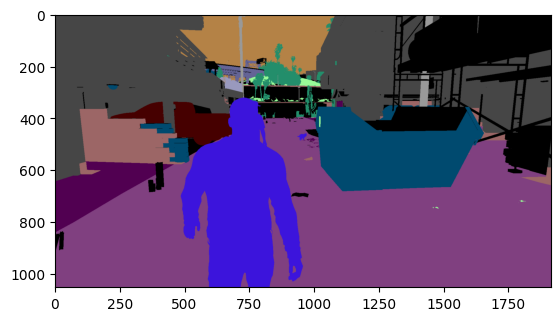

In [ ]:
plt.imshow(real_image)

In [ ]:
TEST_PATHS = "/content/drive/MyDrive/Colab Notebooks/city/test/"


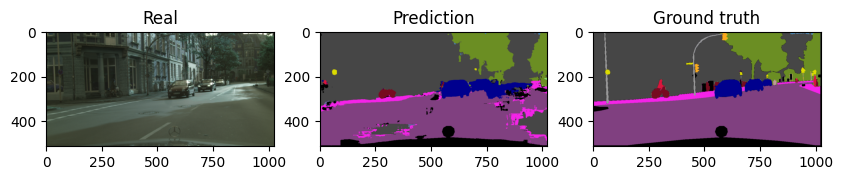

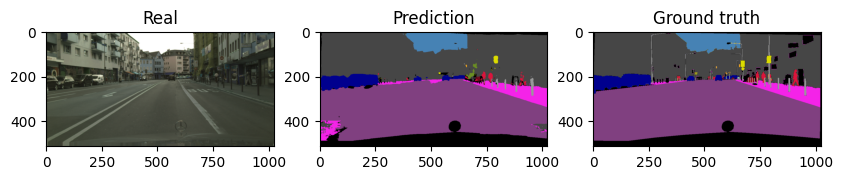

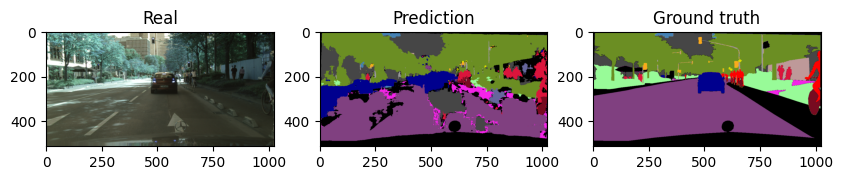

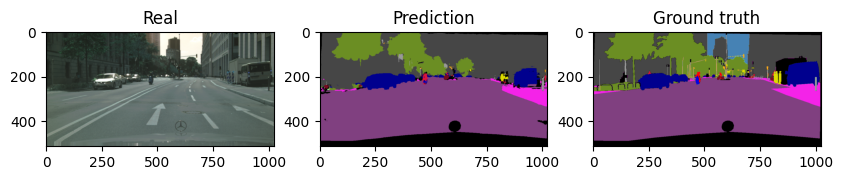

In [ ]:
imagePaths = [f for f in os.listdir(TEST_PATHS) if f.startswith("image_")]
imagePaths = np.random.choice(imagePaths, size=4)
test_images=[]
map_images=[]
for image_file in imagePaths:
        # Extract image number from the filename
        image_number = image_file.split("_")[1].split(".")[0]

        # Construct filenames for the image and label map
        image_filename = f"/content/drive/MyDrive/Colab Notebooks/city/test/image_{image_number}.png"
        map_filename = f"/content/drive/MyDrive/Colab Notebooks/city/test/label_{image_number}.png"
        test_images.append(image_filename)
        map_images.append(map_filename)


for i in range(len(test_images)):
	# make predictions and visualize the results
	make_predictions(model_eval, test_images[i],map_images[i])

